# Importing Libraries and modules


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform, exposure
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


# Define path of signatures

In [11]:
genuine_image_path = r"C:\Users\divis\OneDrive\Documents\Signature-Verification-using-machine-learning-main\real"
forged_image_path = r"C:\Users\divis\OneDrive\Documents\Signature-Verification-using-machine-learning-main\forged"

# Preprocessing the image

In [12]:
def load_and_preprocess_images(genuine_path, forged_path):
    data = []
    labels = []
    
    for file in os.listdir(genuine_path):
        if file.endswith(".png"):
            img = io.imread(os.path.join(genuine_path, file), as_gray=True)
            # Enhanced preprocessing
            img = exposure.equalize_adapthist(img)  # Contrast enhancement
            img = transform.resize(img, (128, 128))
            img = (img - np.mean(img)) / np.std(img)  # Normalization
            data.append(img)
            labels.append(1)
    
    for file in os.listdir(forged_path):
        if file.endswith(".png"):
            img = io.imread(os.path.join(forged_path, file), as_gray=True)
            img = exposure.equalize_adapthist(img)
            img = transform.resize(img, (128, 128))
            img = (img - np.mean(img)) / np.std(img)
            data.append(img)
            labels.append(0)
    
    data = np.array(data)
    data = data.reshape((data.shape[0], 128, 128, 1))
    labels = np.array(labels)
    
    return data, labels


In [13]:
def create_data_generator():
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest'
    )

## Define the CNN model

In [14]:
# Improved CNN model
def create_improved_model(input_shape):
    model = Sequential([
        GaussianNoise(0.1, input_shape=input_shape),
        
        # First Conv Block
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Conv Block
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third Conv Block
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Dense Layers
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
  


In [15]:
input_shape = (128, 128, 1)  # Matches preprocessed image shape in the notebook
model = create_improved_model(input_shape)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_2                │ (None, 64, 64, 1)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,671,617 (36.89 MB)

 Trainable params: 9,668,289 (36.88 MB)

 Non-trainable params: 3,328 (13.00 KB)

# Train the model

In [16]:
from sklearn.model_selection import train_test_split


data, labels = load_and_preprocess_images(genuine_image_path, forged_image_path)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [17]:
input_shape = X_train.shape[1:]  # (128, 128, 1)
model = create_improved_model(input_shape)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

c:\Users\divis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\regularization\gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 67s 11s/step - accuracy: 0.5097 - loss: 3.0560 - val_accuracy: 0.4750 - val_loss: 2.7550
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.6890 - loss: 2.7375 - val_accuracy: 0.4750 - val_loss: 2.7609
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.7812 - loss: 2.6041 - val_accuracy: 0.4750 - val_loss: 2.7646
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 59s 12s/step - accuracy: 0.7788 - loss: 2.5579 - val_accuracy: 0.4750 - val_loss: 2.7638
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.8438 - loss: 2.4367 - val_accuracy: 0.4750 - val_loss: 2.7674
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.8592 - loss: 2.3920 - val_accuracy: 0.4750 - val_loss: 2.7760
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 58s 14s/step - accuracy: 0.8930 - loss: 2.3210 - val_accuracy: 0.4750 - val_loss: 2.7813
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.9019 - loss: 2.3404 - val_accuracy: 0.4750 - val_loss: 2.78

# Plot learning curve for model

In [28]:
def plot_learning_curve(history):
    plt.plot(history.history['accuracy'], label='Train')
    
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()


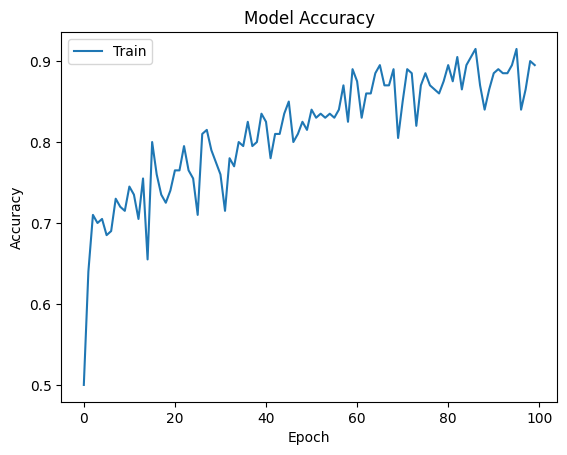

In [30]:
plot_learning_curve(history)

In [25]:
# Print average accuracy across folds
print(f'\nAverage accuracy across {n_splits} folds: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}')

# Train final model on all data
final_model = create_improved_model((128, 128, 1))
history = final_model.fit(
    datagen.flow(data, labels, batch_size=32),
    epochs=100,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)



Average accuracy across 5 folds: 0.4500 ± 0.0000
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5075 - loss: 3.2903 - learning_rate: 1.0000e-04
Epoch 2/100


c:\Users\divis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\divis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6281 - loss: 2.8535 - learning_rate: 1.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6816 - loss: 2.8297 - learning_rate: 1.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7076 - loss: 2.8261 - learning_rate: 1.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6644 - loss: 2.8069 - learning_rate: 1.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6723 - loss: 2.8145 - learning_rate: 1.0000e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6889 - loss: 2.8243 - learning_rate: 1.0000e-04
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7094 - loss: 2.6588 - learning_rate: 1.0000e-04
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7257 - loss: 2.6466 - learning_rate: 1.0000e-04
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7309 - loss: 2.6648 - learning_rate: 1.0000e-04
Epoch 11/100

# Test  and evaluate the Model

In [34]:
# Function to predict signature
def predict_signature(model, img_path):
    img = io.imread(img_path, as_gray=True)
    img = exposure.equalize_adapthist(img)
    img = transform.resize(img, (128, 128))
    img = (img - np.mean(img)) / np.std(img)
    img = np.array(img).reshape((1, 128, 128, 1))
    prediction = model.predict(img)
    print("Prediction probability:", prediction[0][0])
    return prediction[0][0] > 0.5

# Example usage
person_id = input("Enter person ID (e.g., 001): ")
image_path = input("Enter image path: ")
result = predict_signature(final_model, image_path)
print("Genuine" if result else "Forged")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction probability: 0.0124127725
Forged
